In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import pickle
import cv2
%matplotlib inline

In [4]:
# load all the models
haar = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# pickle files
mean  = pickle.load(open('mean_preprocess.pickle','rb'))
model_svm  = pickle.load(open('model_svm.pickle','rb'))
model_pca  = pickle.load(open('pca_50.pickle','rb'))

print('Model loaded sucessfully')

Model loaded sucessfully


In [5]:
gender_pre = ['Male','Female']
font = cv2.FONT_HERSHEY_SIMPLEX

In [6]:
# test data
test_data_path = './data/male_000281.jpg'
color = 'bgr'
# step-1: read image
img = cv2.imread(test_data_path)

def pipeline_model(img,color='rgb'):
    # step-2: convert into gray scale
    if color == 'bgr':
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # step-3: crop the face (using haar cascase classifier)
    faces = haar.detectMultiScale(gray,1.5,3)
    for x,y,w,h in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2) # drawing rectangle
        roi = gray[y:y+h,x:x+w] # crop image
        # step - 4: normalization (0-1)
        roi = roi / 255.0
        # step-5: resize images (100,100)
        if roi.shape[1] > 100:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
        else:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)
        # step-6: Flattening (1x10000)
        roi_reshape = roi_resize.reshape(1,10000) # 1,-1
        # step-7: subptract with mean
        roi_mean = roi_reshape - mean
        # step -8: get eigen image
        eigen_image = model_pca.transform(roi_mean)
        # step -9: pass to ml model (svm)
        results = model_svm.predict_proba(eigen_image)[0]
        # step -10:
        predict = results.argmax() # 0 or 1 
        score = results[predict]
        # step -11:
        text = "%s : %0.2f"%(gender_pre[predict],score)
        cv2.putText(img,text,(x,y),font,1,(0,255,0),2)
    return img

In [7]:
eig_img = model_pca.inverse_transform(eigen_image)

NameError: name 'eigen_image' is not defined

In [8]:
plt.imshow(eig_img.reshape((100,100)),cmap='gray')

NameError: name 'eig_img' is not defined

In [9]:
from PIL import Image

In [10]:
import matplotlib.image as mat_image

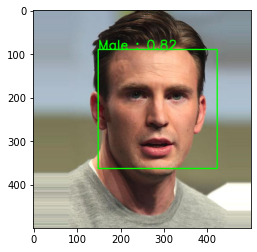

In [12]:
test_data_path = 'male_000281.jpg'
color = 'bgr'
# step-1: read image
img = Image.open(test_data_path) # rgb
# step2: convert into array
img = np.array(img)
# step3: pass to pipeline model
img = pipeline_model(img)
plt.imshow(img)

In [18]:
cap = cv2.VideoCapture('video.mp4')

while True:
    ret, frame = cap.read() # bgr
    
    if ret == False:
        break
    
    frame = pipeline_model(frame,color='bgr')
    
    cv2.imshow('Gender Detector',frame)
    if cv2.waitKey(10) == ord('s'): # press s to exit  --#esc key (27), 
        break
        
cv2.destroyAllWindows()
cap.release()